In [1]:
cd ..

/home/abhishekabhishek/git/UnsupGenModbyMPS


In [2]:
%load_ext autoreload

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
import tensornetwork as tn

from MPScumulant import MPS_c
import mps_circuit_helpers as helpers
import mps_circuit
import metrics
import mps_helpers

In [4]:
# load and format the data
data = np.load('BStest/BSdata.npy')
data_states = data.reshape(-1, 16).astype(np.int8)

In [43]:
# load the trained MPS (with max_bond_dim = 4)
m = MPS_c(16, max_bond_dim=4)
m.loadMPS('BS-4-MPS')

# check the properties of the matrices in the MPS
for i in range(len(m.matrices)):
    tn_core = m.matrices[i]
    print(i, tn_core.shape)

0 (1, 2, 2)
1 (2, 2, 4)
2 (4, 2, 4)
3 (4, 2, 4)
4 (4, 2, 4)
5 (4, 2, 4)
6 (4, 2, 4)
7 (4, 2, 4)
8 (4, 2, 4)
9 (4, 2, 4)
10 (4, 2, 4)
11 (4, 2, 4)
12 (4, 2, 4)
13 (4, 2, 4)
14 (4, 2, 2)
15 (2, 2, 1)


In [44]:
m.bond_dimension

array([2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1], dtype=int16)

In [45]:
type(m)

MPScumulant.MPS_c

Attempt to create a tensornetwork MPS using the above core tensors

In [46]:
tn_mps = tn.FiniteMPS(m.matrices, canonicalize=False)

In [47]:
tn_mps

In [48]:
tn_mps.bond_dimensions, tn_mps.physical_dimensions

([1, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1],
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [9]:
tn_mps.check_canonical()

ValueError: FiniteMPS.center_positions is `None`. Cannot check canonical form.

In [10]:
# try to left canonicalize the MPS
tn_mps.center_position = len(m.matrices)-1
tn_mps.position(len(m.matrices)-1)

1.4142135623730951

In [11]:
tn_mps.check_canonical()

0.7090506896529838

In [12]:
tn_mps.canonicalize()

0.9999999999999999

Check if all the tensor are left isometries after left canonicalization

In [13]:
%autoreload
# check for isometries by reshaping along axis 0
helpers.are_isometries(tn_mps)

idx, core tensor shape, left isometry, right isometry
0 (1, 2, 2) True True
1 (2, 2, 4) True True
2 (4, 2, 4) True False
3 (4, 2, 4) True False
4 (4, 2, 4) True False
5 (4, 2, 4) True False
6 (4, 2, 4) True False
7 (4, 2, 4) True False
8 (4, 2, 4) True False
9 (4, 2, 4) True False
10 (4, 2, 4) True False
11 (4, 2, 4) True False
12 (4, 2, 4) True False
13 (4, 2, 4) True False
14 (4, 2, 2) True False
15 (2, 2, 1) True False


Ok. So looks like left-canonicalization using the tensornetwork methods was successful. Step 0 of load the MPS into the `tensornetwork` framework is complete.

Step 1 : Truncate the MPS to chi = 2

In [20]:
tn_mps.get_tensor(1).shape

(2, 2, 4)

In [21]:
u_prime, v_prime = tn.split_node(tn_mps.get_tensor(1),  max_singular_values=2)

TypeError: split_node() missing 2 required positional arguments: 'left_edges' and 'right_edges'

In [22]:
tn_mps.get_tensor(1).get_edge(0)

AttributeError: 'numpy.ndarray' object has no attribute 'get_edge'

In [30]:
dir(tn_mps)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'apply_one_site_gate',
 'apply_transfer_operator',
 'apply_two_site_gate',
 'backend',
 'bond_dimension',
 'bond_dimensions',
 'canonicalize',
 'center_position',
 'check_canonical',
 'check_orthonormality',
 'connector_matrix',
 'dtype',
 'get_tensor',
 'left_envs',
 'left_transfer_operator',
 'measure_local_operator',
 'measure_two_body_correlator',
 'norm',
 'physical_dimensions',
 'position',
 'qr',
 'random',
 'right_envs',
 'right_transfer_operator',
 'rq',
 'save',
 'svd',
 'tensors']

In [45]:
u_prime, vh_prime = tn.split_node(tn_mps.get_tensor(1), max_singular_values=2)

TypeError: split_node() missing 2 required positional arguments: 'left_edges' and 'right_edges'

In [27]:
u.shape, s.shape, vh.shape

((2, 2, 2), (2,), (2, 4))

In [28]:
helpers.are_isometries(tn_mps)

idx, core tensor shape, left isometry, right isometry
0 (1, 2, 2) True True
1 (2, 2, 4) True True
2 (4, 2, 4) True False
3 (4, 2, 4) True False
4 (4, 2, 4) True False
5 (4, 2, 4) True False
6 (4, 2, 4) True False
7 (4, 2, 4) True False
8 (4, 2, 4) True False
9 (4, 2, 4) True False
10 (4, 2, 4) True False
11 (4, 2, 4) True False
12 (4, 2, 4) True False
13 (4, 2, 4) True False
14 (4, 2, 2) True False
15 (2, 2, 1) True False


In [101]:
u, s, vh, _ = tn_mps.svd(tn_mps.get_tensor(1), max_singular_values=100)

In [82]:
u * (s * vh)

ValueError: operands could not be broadcast together with shapes (2,) (2,4) 

In [102]:
u.shape

(2, 2, 4)

In [109]:
u

array([[[-0.57642012, -0.2736731 ,  0.76962961, -0.02265271],
        [-0.49280746,  0.56097758, -0.18838996, -0.63792961]],

       [[ 0.51107081,  0.61436119,  0.60029469, -0.03183133],
        [-0.40458285,  0.48266709, -0.10874637,  0.769103  ]]])

In [104]:
vh[:, :2]

array([[ 0.,  1.],
       [ 1.,  0.],
       [-0., -0.],
       [ 0.,  0.]])

In [110]:
new_tensor = np.matmul(u[:2], np.matmul(np.diag(s), vh[:, :2]))

In [111]:
np.allclose(tn_mps.get_tensor(1), new_tensor)

ValueError: operands could not be broadcast together with shapes (2,2,4) (2,2,2) 

In [97]:
svh = np.matmul(np.diag(s), vh[:, :2])

In [98]:
svh

array([[0., 1.],
       [1., 0.]])

In [99]:
u

array([[[-0.57642012, -0.2736731 ],
        [-0.49280746,  0.56097758]],

       [[ 0.51107081,  0.61436119],
        [-0.40458285,  0.48266709]]])

In [100]:
np.matmul(u, svh)

array([[[-0.2736731 , -0.57642012],
        [ 0.56097758, -0.49280746]],

       [[ 0.61436119,  0.51107081],
        [ 0.48266709, -0.40458285]]])

In [92]:
new_tensor.shape

(2, 2, 4)

In [69]:
np.diag(s)

array([[1., 0.],
       [0., 1.]])

In [71]:
tn_mps.get_tensor(1).shape

(2, 2, 4)

In [10]:
tn_mps_trun = mps_helpers.truncate_mps(tn_mps, max_singular_values=2)

In [11]:
tn_mps_trun

In [13]:
tn_mps_trun.bond_dimensions, tn_mps_trun.physical_dimensions

([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1],
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

So it looks like we have successfully truncated the chi = 4 MPS to chi = 2 MPS

In [16]:
np.array(tn_mps_trun.bond_dimensions, dtype=np.int16)

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1], dtype=int16)

In [17]:
len(tn_mps_trun.tensors)

16

In [19]:
tn_mps_trun.tensors[0]

numpy.ndarray

In [20]:
type(m.matrices[0])

numpy.ndarray

In [21]:
%autoreload
mps_trun = mps_helpers.tn_to_mps(tn_mps_trun)

In [22]:
# check the properties of the matrices in the MPS
for i in range(len(mps_trun.matrices)):
    tn_core = mps_trun.matrices[i]
    print(i, tn_core.shape)

0 (1, 2, 2)
1 (2, 2, 2)
2 (2, 2, 2)
3 (2, 2, 2)
4 (2, 2, 2)
5 (2, 2, 2)
6 (2, 2, 2)
7 (2, 2, 2)
8 (2, 2, 2)
9 (2, 2, 2)
10 (2, 2, 2)
11 (2, 2, 2)
12 (2, 2, 2)
13 (2, 2, 2)
14 (2, 2, 2)
15 (2, 2, 1)


In [24]:
mps_trun_unitaries = helpers.get_mps_unitaries(mps_trun)

padding the mps core tensors
idx, shape of the padded tensor, updated bond dimension
i = 1, (2, 2, 2), 2
i = 2, (2, 2, 2), 2
i = 3, (2, 2, 2), 2
i = 4, (2, 2, 2), 2
i = 5, (2, 2, 2), 2
i = 6, (2, 2, 2), 2
i = 7, (2, 2, 2), 2
i = 8, (2, 2, 2), 2
i = 9, (2, 2, 2), 2
i = 10, (2, 2, 2), 2
i = 11, (2, 2, 2), 2
i = 12, (2, 2, 2), 2
i = 13, (2, 2, 2), 2
i = 14, (2, 2, 2), 2
left canonicalizing the padded MPS
bond: 0
bond: 1
bond: 2
bond: 3
bond: 4
bond: 5
bond: 6
bond: 7
bond: 8
bond: 9
bond: 10
bond: 11
bond: 12
bond: 13
bond: 14


This is now the most important part - we've been able to extract the list of unitaries corresponding to the truncated chi = 2 MPS.

Now, we just have to figure out on how to apply the conjugate transpose of this to the original MPS (i.e. the disentangle step) and contract and truncate (i.e. the iterative step)

In [25]:
len(mps_trun_unitaries)

16

In [26]:
mps_circ = mps_circuit.mps_unitaries_to_circuit(mps_trun_unitaries)

(<Figure size 1368x1224 with 1 Axes>, <Axes: >)

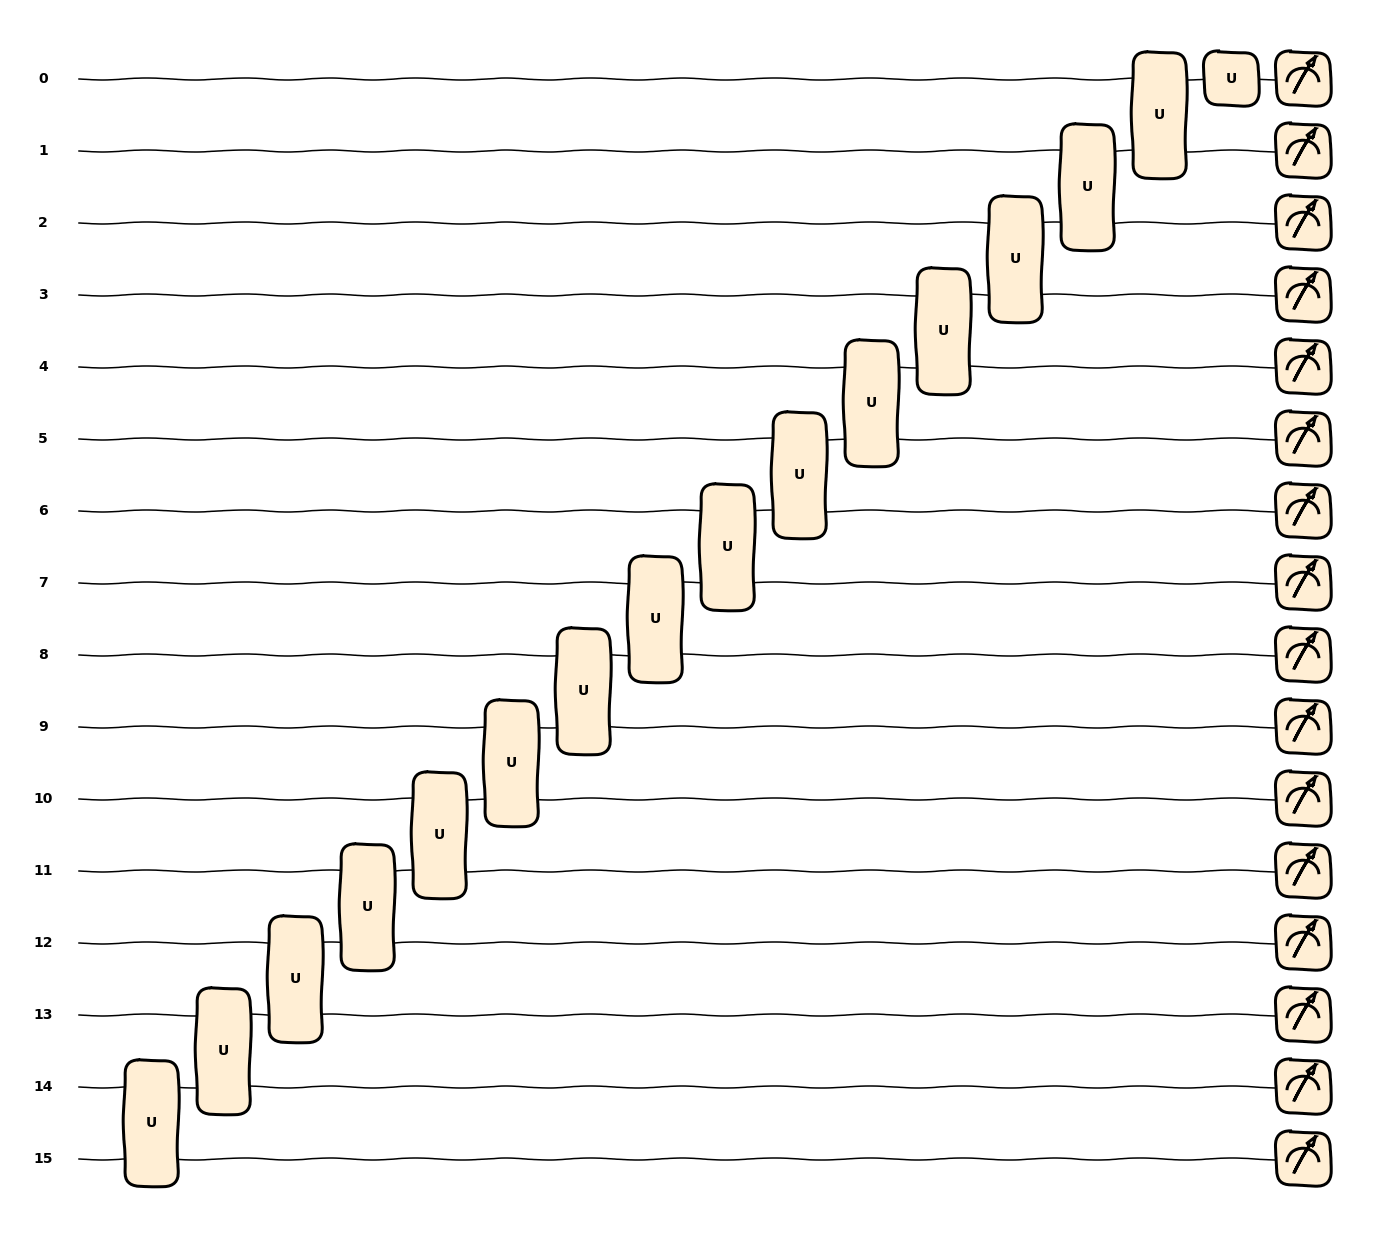

In [27]:
qml.drawer.draw_mpl(mps_circ, style="sketch")()

So, we need to apply the conjugate dagger of the above circuit to the MPS which pretty much just looks like applying the unitaries in our mps unitaries list to the `tn.FiniteMPS` in a specified order.

In what order, do we have the unitaries right now

In [29]:
for idx, unitary in enumerate(mps_trun_unitaries):
    print(idx, unitary.shape)

0 (2, 2)
1 (4, 4)
2 (4, 4)
3 (4, 4)
4 (4, 4)
5 (4, 4)
6 (4, 4)
7 (4, 4)
8 (4, 4)
9 (4, 4)
10 (4, 4)
11 (4, 4)
12 (4, 4)
13 (4, 4)
14 (4, 4)
15 (4, 4)


It looks like they're already in the right order - so we just need to do conjugate transpose and make sure we apply them to the correct site

In [49]:
disentangler = []
for unitary in mps_trun_unitaries:
    disentangler.append(unitary.conj().T)

So, we've prepared the disentangler - now let's apply this to the MPS using `tensornetwork`:

In [52]:
# apply the single site gate first
tn_mps.apply_one_site_gate(disentangler[0], site=0)

# apply the two site gates (hopefully) in the correct order
for idx in range(len(disentangler)-1):
    gate = disentangler[idx+1]
    gate = gate.reshape(2, 2, 2, 2)
    # need to set the center position
    tn_mps.center_position = idx
    tn_mps.position(idx)
    tn_mps.apply_two_site_gate(gate, site1=idx, site2=idx+1,
                               max_singular_values=4)

**Not sure on the correctness** of the above procedure but let's look at what the resulting MPS looks like

In [53]:
tn_mps.bond_dimensions, tn_mps.physical_dimensions

([1, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1],
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Ok. That really blew up the bond dimensions from 

```[1, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1]```

to what we have above:

```[1, 2, 4, 8, 16, 32, 32, 32, 32, 32, 32, 32, 16, 8, 4, 2, 1]```

How and by how much should I truncate the above ? Is the goal to get the bond dimensions back to the original ones and repeat the procedure ?

Ok. Looks like we can get the bond dimension under control by truncating using max singular values. Now, can this procedure be done iteratively, and somehow we can get a list of list of unitaries - and check to see if the fidelity goes up compared to the simply mapped MPS.

Steps:
1. Given a MPS $\psi_{\chi_{max}}$
2. Repeat the following until a no. of maximum 2-qubit layers $K$ or good agreement b/w fidelity of the layered circuit to the true MPS circuit is reached.
3. Truncate to chi = 2 : $\psi^{k}_{\chi = 2}$
4. Get the disentangler corresponding to the $\psi^{k}_{\chi = 2}$ MPS
5. Apply the disentangler to $\psi^{k}_{\chi?}$
6. Repeat the process

Is there some way to visualize the fidelity as the increase the depth $K$ of the layer circuits ? I guess we should write a function that takes in those list of list of unitaries -> creates a quantum circuit and compute the fidelity w.r.t. to the original MPS circuit

In [ ]:
# convert to a MPScumulant.MPS object and extract the 2-qubit unitaries
mps_unitaries = get_mps_unitaries(tn_to_mps(mps))